## Import library yang dibutuhkan

In [1]:
import numpy as np # untuk mengolah data
import pandas as pd # untuk mengolah data 
import matplotlib.pyplot as plt # untuk visualisai diagram

from sklearn.preprocessing import LabelEncoder # untuk encode kategori
from sklearn.preprocessing import MinMaxScaler # untuk normalisasi data

import tensorflow as tf # untuk membuat model neural network

from sklearn.neighbors import KNeighborsClassifier # untuk membuat model KNN
from sklearn.metrics import accuracy_score # untuk mengukur akurasi model KNN

## Exploratory Data Analysis (EDA)

### membaca data dari csv

In [2]:
data = pd.read_csv('dataset/updated_pollution_dataset.csv')

print(data.head())
print(f'Panjang data: {len(data)}')

   Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         29.8      59.1    5.2  17.9  18.9   9.2  1.72   
1         28.3      75.6    2.3  12.2  30.8   9.7  1.64   
2         23.1      74.7   26.7  33.8  24.4  12.6  1.63   
3         27.1      39.1    6.1   6.3  13.5   5.3  1.15   
4         26.5      70.7    6.9  16.0  21.9   5.6  1.01   

   Proximity_to_Industrial_Areas  Population_Density Air Quality  
0                            6.3                 319    Moderate  
1                            6.0                 611    Moderate  
2                            5.2                 619    Moderate  
3                           11.1                 551        Good  
4                           12.7                 303        Good  
Panjang data: 5000


### mencari null value

In [3]:
null_val = data.isnull().sum(axis=0)
print(null_val)

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64


di sini dapat dilihat bahwa tidak ada null value pada dataset

### mencari data yang duplikat

In [4]:
duplicate_val = data.duplicated().sum()
print(f'jumlah data duplikat: {duplicate_val}') # output jumlah data duplikat: 0

jumlah data duplikat: 0


disini dapat dilihat bahwa tidak ada data yang duplikat

### melihat distribusi data untuk mendeteksi outlier

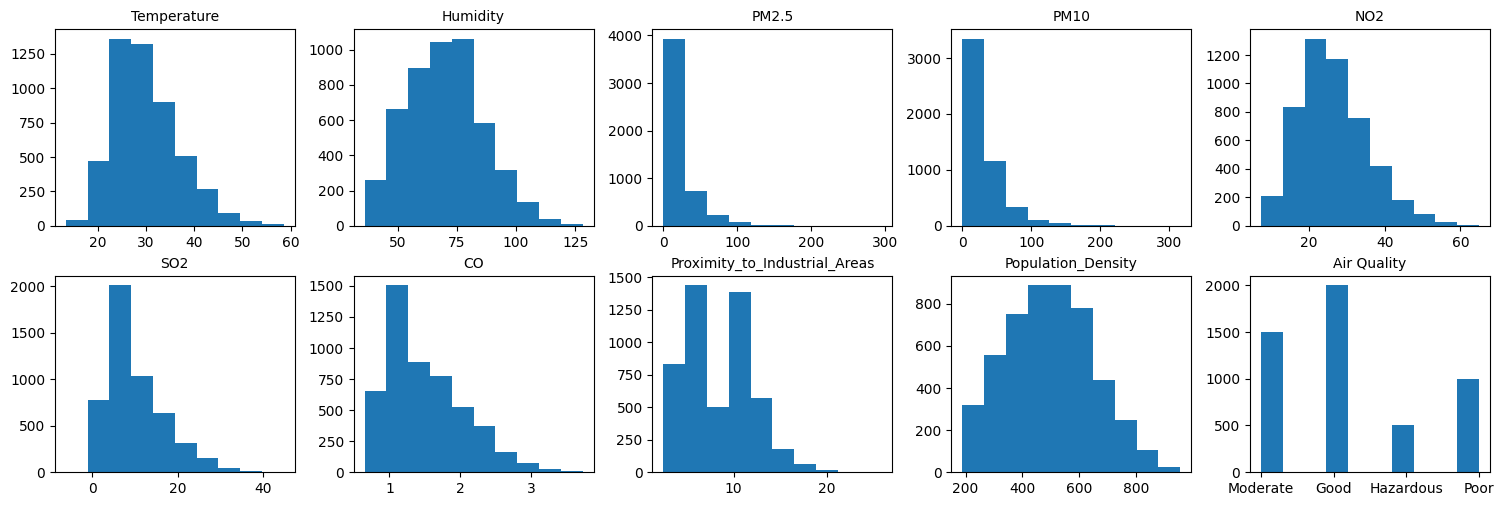

In [5]:
plt.figure(figsize=(15,5))

for i,col in enumerate(data):
    plt.subplot(2,5,i+1)
    plt.title(col,fontsize=10)
    plt.hist(data[col])

plt.tight_layout(pad=0.5)
plt.show()

In [6]:
data_val = pd.DataFrame(columns=['max','min','mean','std'], index=data.columns[:-1])

for i in data:
    if i!='Air Quality':
        data_val.loc[i, 'max'] = np.max(data[i])
        data_val.loc[i, 'min'] = np.min(data[i])
        data_val.loc[i, 'mean'] = np.mean(data[i])
        data_val.loc[i, 'std'] = np.std(data[i])

print(data_val)

                                 max   min      mean         std
Temperature                     58.6  13.4  30.02902    6.719989
Humidity                       128.1  36.0  70.05612    15.86199
PM2.5                          295.0   0.0  20.14214    24.55209
PM10                           315.8  -0.2  30.21836   27.346464
NO2                             64.9   7.4   26.4121    8.894467
SO2                             44.9  -6.2  10.01482    6.749628
CO                              3.72  0.65  1.500354    0.545972
Proximity_to_Industrial_Areas   25.8   2.5    8.4254    3.610583
Population_Density               957   188  497.4238  152.738808


Di sini terlihat ada beberapa data yang kemungkinan besar merupakan outlier. Contohnya pada kolom PM10 dan SO2 di mana nilai min mencapai angka minus(-) dan juga pada kolom temperatur dengan nilai max 58.6'C

## Data Preparation

### menghilangkan outlier dengan metode interkuartil

In [ ]:
filtered_data = data.copy()

for i in ['Temperature','PM10','SO2']:
    # mencari IQR
    Q1 = filtered_data[i].quantile(0.25)
    Q3 = filtered_data[i].quantile(0.75)
    IQR = Q3 - Q1
    
    # Batas bawah dan atas
    alpha = 0.50 # mengatur pengambilan data
    lower_bound = Q1 - alpha * IQR
    upper_bound = Q3 + alpha * IQR
    filtered_data = filtered_data[ (filtered_data[i] >= lower_bound) & (filtered_data[i] <= upper_bound) ]
print(f"Jumlah data awal: {len(data)}")
print(f"Jumlah data setelah filter: {len(filtered_data)}")

# cek ulang value distribusi data
data_val = pd.DataFrame(columns=['max','min','mean','std'], index=data.columns[:-1])
for i in filtered_data:
    if i!='Air Quality':
        data_val.loc[i, 'max'] = np.max(filtered_data[i])
        data_val.loc[i, 'min'] = np.min(filtered_data[i])
        data_val.loc[i, 'mean'] = np.mean(filtered_data[i])
        data_val.loc[i, 'std'] = np.std(filtered_data[i])
print('\n')
print(data_val)

Jumlah data awal: 5000
Jumlah data setelah filter: 2920


                                 max   min        mean         std
Temperature                     38.4  20.7   27.617979    4.065383
Humidity                       109.9  36.0   65.310479   13.706441
PM2.5                           43.3   0.0   10.833288     9.10017
PM10                            45.9   1.0   18.309521   10.319288
NO2                             62.1   7.4   22.964795    6.798435
SO2                             14.3   1.4    6.877226    3.138061
CO                              3.11  0.65    1.251469    0.368765
Proximity_to_Industrial_Areas   25.8   2.6    9.790685    3.332958
Population_Density               927   188  446.744178  132.164893


Dengan metode interkuartil, kita memotong data yang jauh dari rata-rata data yang ada sehingga diharapkan data outlier tidak ikut masuk dalam data training untuk model machine learning kita

### Encoding kategori dengan labelEncoder() untuk merubah bentuk kategori menjadi angka

In [15]:
# encode bagian air quality
le = LabelEncoder()
filtered_data['Air Quality'] = le.fit_transform(filtered_data['Air Quality'])
print(filtered_data['Air Quality'])

0       2
1       2
2       2
3       0
4       0
       ..
4992    0
4994    0
4996    2
4997    2
4998    0
Name: Air Quality, Length: 2920, dtype: int64


tahapan ini dilakukan untuk merubah data di kolom 'Air Quality' menjadi angka. hal ini dimaksudkan untuk mempermudah model machine learning untuk melakukan klasifikasi

### Normalisasi data menggunakan MinMax method

In [16]:
minmax = MinMaxScaler()
normalized_X = pd.DataFrame(minmax.fit_transform(filtered_data.iloc[:, :-1].values))
labels = filtered_data.iloc[:, -1].values
print(normalized_X.head())

          0         1         2         3         4         5         6  \
0  0.514124  0.312585  0.120092  0.376392  0.210238  0.604651  0.434959   
1  0.429379  0.535859  0.053118  0.249443  0.427788  0.643411  0.402439   
2  0.135593  0.523681  0.616628  0.730512  0.310786  0.868217  0.398374   
3  0.361582  0.041949  0.140878  0.118040  0.111517  0.302326  0.203252   
4  0.327684  0.469553  0.159353  0.334076  0.265082  0.325581  0.146341   

          7         8  
0  0.159483  0.177267  
1  0.146552  0.572395  
2  0.112069  0.583221  
3  0.366379  0.491204  
4  0.435345  0.155616  


normalisasi dilakukan agar proses meminimalisir cost function menjadi lebih optimal karena semua fitur kini memiliki bobot yang relatif sama. Metode MinMax dipilih agar jangkauan data berada di rentang [0,1]

### train-test split (90%:10%) dengan list slicing

In [10]:
treshold = int(len(filtered_data)*0.9)

X_train = normalized_X[:treshold]
y_train = labels[:treshold]

X_test = normalized_X[treshold:]
y_test = labels[treshold:]

print(len(X_train))
print(len(X_test))

2628
292


tahap terakhir dalam menyiapkan data adalah membuat training set dan test set. ukuran dari training set harus lebih besar dibanding test set karena training set adalah dasar bagi model machine learning untuk merubah parameter dan memberikan prediksi. karena itu, pembagian 90%:10% dipilih untuk memberikan dasar parameter yang baik pada model machine learning.

## Modelling

### KNN(K Nearest Neighbors)

In [17]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accKNN = accuracy_score(y_test, y_pred)
print("Akurasi:", accKNN)

Akurasi: 0.9417808219178082


pada model KNN yang dibuat dapat dilihat bahwa akurasi yang dihasilkan ~94%

### Neural Network

In [18]:
inputs = tf.keras.layers.Input(shape=(9,))
x = tf.keras.layers.Dense(20, activation='relu')(inputs)
x = tf.keras.layers.Dense(20, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.fit(X_train,y_train,batch_size=32,epochs=10,verbose=2)
loss, accNN = model.evaluate(X_test,y_test,batch_size=32,verbose=2)
print("Akurasi:", accNN)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            84 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 704 (2.75 KB)

 Trainable params: 704 (2.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
83/83 - 1s - 16ms/step - accuracy: 0.5422 - loss: 1.1379
Epoch 2/10
83/83 - 0s - 3ms/step - accuracy: 0.6667 - loss: 0.7529
Epoch 3/10
83/83 - 0s - 3ms/step - accuracy: 0.8695 - loss: 0.4934
Epoch 4/10
83/83 - 0s - 3ms/step - accuracy: 0.8999 - loss: 0.3323
Epoch 5/10
83/83 - 0s - 3ms/step - accuracy: 0.9129 - loss: 0.2522
Epoch 6/10
83/83 - 0s - 4ms/step - accuracy: 0.9418 - loss: 0.2059
Epoch 7/10
83/83 - 0s - 3ms/step - accuracy: 0.9532 - loss: 0.1757
Epoch 8/10
83/83 - 0s - 3ms/step - accuracy: 0.9578 - loss: 0.1567
Epoch 9/10
83/83 - 0s - 3ms/step - accuracy: 0.9600 - loss: 0.1435
Epoch 10/10
83/83 - 0s - 3ms/step - accuracy: 0.9612 - loss: 0.1332
10/10 - 0s - 21ms/step - accuracy: 0.9658 - loss: 0.1375
Akurasi: 0.965753436088562


pada model neural network yang dibuat yang dibuat dapat dilihat bahwa akurasi yang dihasilkan ~96.5% yang mana akurasi ini lebih tinggi dibanding model KNN